# Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

## Import Library

In [1]:
import pandas as pd
import tensorflow_data_validation as tfdv
from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow import feature_column as fc
from tensorflow.keras.callbacks import TensorBoard
from functools import partial

## Import file in a DataFrame pandas

In [3]:
df = pd.read_csv('./data/logement-encadrement-des-loyers.csv', sep=';')
df.head(2)

,id_zone,id_quartier,nom_quartier,piece,epoque,meuble_txt,ref,max,min,annee,ville,code_grand_quartier,geo_shape,geo_point_2d
0,11,77,Belleville,4,Avant 1946,non meublé,21.4,25.68,14.98,2020,PARIS,7512077,"{""type"": ""Polygon"", ""coordinates"": [[[2.383226...","48.8715312006,2.38754923985"
1,13,75,Amérique,3,1971-1990,non meublé,16.7,20.04,11.69,2020,PARIS,7511975,"{""type"": ""Polygon"", ""coordinates"": [[[2.409402...","48.8816381673,2.39544016662"


## Processing the dataframe 

Remove the column `geo_shape`and create two columns for the `longitute` and `latitude`.

In [4]:
def df_processing(df):
    
    # Create the columns for the latitude and longitude
    df_lat_lon = df['geo_point_2d'].str.split(',', expand=True)
    df['lat'] = df_lat_lon[0].astype(float) 
    df['lon'] = df_lat_lon[1].astype(float)
    
    # Deleted the column 'geo_shape'
    df = df.drop(['geo_shape','geo_point_2d'], axis=1)
    
    df_processed = df
    
    return df_processed

In [5]:
# Show the DataFrame
df_logement = df_processing(df)
df_logement.head(2)

,id_zone,id_quartier,nom_quartier,piece,epoque,meuble_txt,ref,max,min,annee,ville,code_grand_quartier,lat,lon
0,11,77,Belleville,4,Avant 1946,non meublé,21.4,25.68,14.98,2020,PARIS,7512077,48.871531,2.387549
1,13,75,Amérique,3,1971-1990,non meublé,16.7,20.04,11.69,2020,PARIS,7511975,48.881638,2.395440


## Explorating Data Analysis (EDA)

In [6]:
df_logement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_zone              2560 non-null   int64  
 1   id_quartier          2560 non-null   int64  
 2   nom_quartier         2560 non-null   object 
 3   piece                2560 non-null   int64  
 4   epoque               2560 non-null   object 
 5   meuble_txt           2560 non-null   object 
 6   ref                  2560 non-null   float64
 7   max                  2560 non-null   float64
 8   min                  2560 non-null   float64
 9   annee                2560 non-null   int64  
 10  ville                2560 non-null   object 
 11  code_grand_quartier  2560 non-null   int64  
 12  lat                  2560 non-null   float64
 13  lon                  2560 non-null   float64
dtypes: float64(5), int64(5), object(4)
memory usage: 280.1+ KB


In [7]:
# .apply for remoce the scientist notation
df_logement.describe().T.apply(lambda s: s.apply('{0:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
id_zone,2560.000,6.662,4.226,1.000,3.000,5.000,11.000,14.000
id_quartier,2560.000,40.500,23.097,1.000,20.750,40.500,60.250,80.000
piece,2560.000,2.500,1.118,1.000,1.750,2.500,3.250,4.000
ref,2560.000,25.727,4.182,14.600,22.900,25.300,28.300,39.600
max,2560.000,30.873,5.018,17.520,27.480,30.360,33.960,47.520
min,2560.000,18.009,2.927,10.220,16.030,17.710,19.810,27.720
annee,2560.000,2020.000,0.000,2020.000,2020.000,2020.000,2020.000,2020.000
code_grand_quartier,2560.000,7511090.500,599.811,7510101.000,7510595.750,7511090.500,7511585.250,7512080.000
lat,2560.000,48.861,0.018,48.823,48.849,48.862,48.874,48.896
lon,2560.000,2.344,0.035,2.252,2.324,2.345,2.364,2.433


In [8]:
stats = tfdv.generate_statistics_from_dataframe(df_logement)
tfdv.visualize_statistics(stats)

## Create batch data for Training, Evaluation and Test

In [9]:
# 90% of the data for the training and evaluation,  10% for the test.
df_train_eval, df_test = train_test_split(df_logement, test_size=0.1, random_state=21) # andom_state is used for keep the same random state

# 80% of the 90% for training et 20% of the 90% for the evaluation
df_train, df_eval = train_test_split(df_train_eval, test_size=0.2, shuffle=False) # shuffle to false because the data had already be shuffle in the first split

print("Training and Evaluation: {} examples".format(len(df_train_eval)))
print("Test: {} examples".format(len(df_test)))
print()
print("Training: {} examples".format(len(df_train)))
print("Evaluation: {} examples".format(len(df_eval)))

Training and Evaluation: 2304 examples
Test: 256 examples

Training: 1843 examples
Evaluation: 461 examples


## Save the DataFrames

In [10]:
df_train.to_csv('./data/logement-train.csv', sep=',', index=False)
df_eval.to_csv('./data/logement-eval.csv', sep=',', index=False)
df_test.to_csv('./data/logement-test.csv', sep=',', index=False)

## Read the CSV files with `pandas` and `Dataset.from_tensor_slices`

Methode for load the data into tensorflow with a DataFrame Pandas.

In [11]:
LABEL_COLUMN = 'ref'
MINI_BATCH_SIZE = 50
UNWANTED_COLS = ['code_grand_quartier', 'ville','annee','min', 'max']

def df_to_tf_dataset(dataframe, shuffle=True):
    '''Function for load a DataFrame pandas into tensorflow dataset'''
    
    df = dataframe.copy()
    label = df.pop(LABEL_COLUMN)
    # Remove the unwanted columns
    df = df[[column_name for column_name in df.columns.tolist() if column_name not in UNWANTED_COLS]]
    
    # Create the tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), label)) 
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=21)
        
    # Create the mini batches of exemples
    dataset = dataset.batch(MINI_BATCH_SIZE)
    
    return dataset 

def show_data(dataset):
    '''Function for display the data of a tensorflow dataset'''
    
    for batch, labels in dataset.take(1):
        print('Labels:', labels.numpy())
        print()
        print('Features:\n')
        for key, value in batch.items():
            print('{}: {}'.format(key, value.numpy()))

Create the tensorflow dataset for Train, Eval and Test the model

In [12]:
df_train = pd.read_csv('./data/logement-train.csv')
df_eval = pd.read_csv('./data/logement-eval.csv')
df_test = pd.read_csv('./data/logement-eval.csv')

train = df_to_tf_dataset(df_train, shuffle=False)
eval_ = df_to_tf_dataset(df_eval, shuffle=False)
test = df_to_tf_dataset(df_test, shuffle=False)

In [13]:
#show_data(train)

## Read the CSV files with `tf.data`

An other methode for load the data of file in a tensorflow dataset.
The data is load directly from the csv file(s).

In [14]:
CSV_COLUMNS = ['id_zone', 'id_quartier', 'nom_quartier', 'piece', 'epoque', 'meuble_txt', 'ref', 'max', 'min',
               'annee', 'ville', 'code_grand_quartier', 'lat', 'lon']

MINI_BATCH_SIZE = 50
LABEL_COLUMN = 'ref'
DEFAULTS = [[0.0], [0.0], ['na'], [0.0], ['na'], ['na'], [0.0], [0.0], [0.0], [0.0], ['na'], [0.0], [0.0] , [0.0]]
UNWANTED_COLS = ['ville','annee','min', 'max']


def features_and_labels(row_data):
    '''This function separate the features and label from the dataset and remove the unwanted columns'''
    
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    # Remove the unwanted columns
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)
        
    return features, label


# Reading CSV files into a dataset
def create_dataset(pattern, mini_batch_size=1, shuffle=True):
    '''This function load the data from csv files into a tensorflow datasets'''
    
    dataset = tf.data.experimental.make_csv_dataset(pattern,
                                                   MINI_BATCH_SIZE,
                                                   CSV_COLUMNS,
                                                   DEFAULTS,
                                                   shuffle=False) # the dataset is shuffle after
    
    
    dataset = dataset.map(features_and_labels)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=21).repeat()
        
    # take advantage of multi-threading; 1=AUTOTUNE
    dataset= dataset.prefetch(1)
    
    return dataset


def show_data(dataset):
    '''Function for display the data of a tensorflow dataset'''
    
    for batch, labels in dataset.take(1):
        print('Labels:', labels.numpy())
        print()
        print('Features:\n')
        for key, value in batch.items():
            print('{}: {}'.format(key, value.numpy()))


Load the datasets for Train, Eval and Test the model

In [15]:
trainds = create_dataset(pattern='./data/logement-train.csv',
                        mini_batch_size=MINI_BATCH_SIZE,
                        shuffle=False)

evalds = create_dataset(pattern='./data/logement-eval*',
                        mini_batch_size=MINI_BATCH_SIZE,
                        shuffle=False)

testds = create_dataset(pattern='./data/logement-test*',
                        mini_batch_size=MINI_BATCH_SIZE,
                        shuffle=False)

In [16]:
#show_data(trainds)

## Scaling the numeric features

In [43]:
# Display the statistics of the train data
desc = df_train[numeric_columns].describe()
desc

,id_quartier,piece,id_zone
count,1843.000000,1843.000000,1843.000000
mean,40.360282,2.504069,6.627781
std,22.943858,1.110780,4.209798
min,1.000000,1.000000,1.000000
25%,21.000000,2.000000,3.000000
50%,40.000000,2.000000,5.000000
75%,60.000000,3.000000,11.000000
max,80.000000,4.000000,14.000000


Get the statistics values.

In [44]:
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['mean'])
MAX = np.array(desc.T['max'])
MIN = np.array(desc.T['min'])

print('Mean            : ', MEAN)
print('Ecart-Type (std): ', STD)
print('Max             : ', MAX)
print('Min             : ', MIN)

Mean            :  [40.36028215  2.50406945  6.62778079]
Ecart-Type (std):  [40.36028215  2.50406945  6.62778079]
Max             :  [80.  4. 14.]
Min             :  [1. 1. 1.]


Set by default the MEAN and STD value for each numeric features of the scaler function.

In [54]:
numeric_columns = ['id_quartier', 'piece', 'id_zone']

def standar_scaler(data, mean=MEAN, std=STD):
    '''
    This function allows to normalize the variables (data) so that they have a zero mean and a variance
    equal to 1. For a variable, this corresponds to subtracting for each observation the mean (mean) of the variable and to dividing each observation
    by the standard deviation (std).
    '''
    
    
    return (data-mean) / std

## Pre-Processing the Input Features 

In [55]:
feature_columns = []

# 1. Numeric coloumns

# Add the feature to the list eature_columns
for col_name in numeric_columns:
    feature_columns.append(fc.numeric_column(col_name,
                                            normalizer_fn=standar_scaler,
                                            shape=[len(numeric_columns)]))
    
# 2. Categorical columns
categorical_column = ['epoque','meuble_txt','nom_quartier']

# Add the feature to the list eature_columns
for col_name in categorical_column:
    catg_val_list = df_train[col_name].unique().tolist()
    feature = fc.categorical_column_with_vocabulary_list(col_name,
                                                         catg_val_list)
    feature_columns.append(fc.indicator_column(feature))
    
# 3. Crossed Columns
lat = fc.numeric_column('lat')
lon = fc.numeric_column('lon')

# The number of bucket corresponds to the number of districts in Paris
nb_bucket = len(df_train['nom_quartier'].unique().tolist())

# Bucketize latitudes and longitudes
latbucket = list(np.linspace(start=48.82313,
                             stop=48.89556,
                             num=nb_bucket))
lonbucket = list(np.linspace(start=2.25228,
                             stop= 2.406172,
                             num=nb_bucket))

bucketized_lat = fc.bucketized_column(lat,
                                      boundaries=latbucket)
bucketized_lon = fc.bucketized_column(lon,
                                      boundaries=lonbucket)

# Crossed features for locations
loc = fc.crossed_column([bucketized_lat, bucketized_lon],
                                   hash_bucket_size=nb_bucket) # No precise for the limited number of bucket

# Add the feature to the list eature_columns
feature_columns.append(fc.indicator_column(loc))


In [56]:
# Create a vector of features
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [57]:
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(units=32, activation="relu", name="h1"),
    layers.Dense(units=8, activation="relu", name="h2"),
    layers.Dense(units=1, activation="linear", name="output")
    ])

In [58]:
# Custum eval metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

Configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

Used a custom metric `rmse` to our list of metrics which will return the root mean square error. 

In [59]:
# Compile the keras model

# Number of exemples divided by the mini batch size
STEPS_PER_EPOCH = len(df_train) // MINI_BATCH_SIZE

model.compile(optimizer="adam",
              loss="mse",
              metrics=[rmse, "mse"])

history = model.fit(trainds,
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=30,
          validation_steps=STEPS_PER_EPOCH,          
          validation_data=evalds)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
28/36 [======================>.......] - ETA: 0s - loss: 642.6464 - rmse: 25.3374 - mse: 642.6464WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('id_zone', <tf.Tensor 'ExpandDims_3:0' shape=(50, 1) dtype=float32>), ('id_quartier', <tf.Tensor 'ExpandDims_2:0' shape=(50, 1) dtype=float32>), ('nom_quartier', <tf.Tensor 'ExpandDims_7:0' shape=(50, 1) dtype=string>), ('piece', <tf.Tensor 'ExpandDims_8:0' shape=(50, 1) dtype=float32>), ('epoque', <tf.Tensor 'ExpandDims_1:0' shape=(50, 1) dtype=string>), ('meuble_txt', <tf.Tensor 'ExpandDims_6:0' shape=(50, 1) dtype=string>), ('code_grand_quartier', <tf.Tensor 'ExpandDims:0' shape=(50, 1) dtype=float32>), ('lat', <tf.Tensor 'ExpandDims_4:0' shape=(50, 1) dtype=float32>), ('lon', <tf.Tensor 'ExpandDims_5:0' shape=(

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [60]:
# The summary() is a generic function used to produce result summaries of the results of various model fitting functions.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_5 (DenseFeatu multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  5632      
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 5,905
Trainable params: 5,905
Non-trainable params: 0
_________________________________________________________________


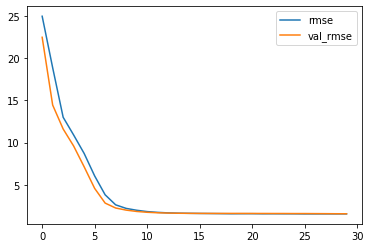

In [61]:
RMSE_COLS = ['rmse', 'val_rmse']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[RMSE_COLS].plot()

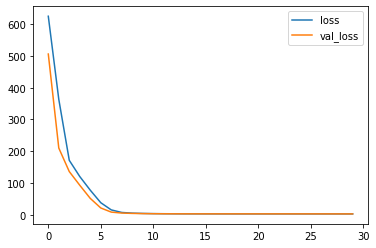

In [62]:
LOSS_COLS = ['loss', 'val_loss']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[LOSS_COLS].plot()

In [63]:
# Evaluation with data never seen by the model
eval_model = model.evaluate(testds, steps=STEPS_PER_EPOCH)

36/36 [==============================] - 0s 2ms/step - loss: 2.5785 - rmse: 1.6031 - mse: 2.5785


## Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [64]:
# The predict() method will predict the response for model. 
# Using tf.convert_to_tensor() we will convert the given value to a Tensor. 

model.predict(x={"epoque": tf.convert_to_tensor(['Avant 1946']),
                 "piece": tf.convert_to_tensor([2]),
                 "id_quartier": tf.convert_to_tensor([77]),
                 "id_zone": tf.convert_to_tensor([11]),
                 "meuble_txt": tf.convert_to_tensor(['non meublé']),
                 "lat": tf.convert_to_tensor([48.8715312006]),
                 "lon": tf.convert_to_tensor([2.38754923985]),
                 "annee": tf.convert_to_tensor([2020]),
                 "code_grand_quartier": tf.convert_to_tensor([7512077]),
                 "max": tf.convert_to_tensor([25.68]),
                 "min": tf.convert_to_tensor([14.98]),
                 "nom_quartier": tf.convert_to_tensor(['Belleville']),
                 "ville": tf.convert_to_tensor(['PARIS'])}, 
              steps=1)

Consider rewriting this model with the Functional API.


array([[27.566711]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [68]:
import os
import shutil
import datetime as dt

OUTPUT_DIR = "./savedmodel"

# shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

# The join() method takes all items in an iterable and joins them into one string.
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           dt.datetime.now().strftime("%Y%m%d%H%M%S"))

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

In [67]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['code_grand_quartier'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_code_grand_quartier:0
  inputs['epoque'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_epoque:0
  inputs['id_quartier'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_id_quartier:0
  inputs['id_zone'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_id_zone:0
  inputs['lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_lat:0
  inputs['lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_lon:0
  inputs['meuble_txt'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_meuble_txt:0
  inputs['nom_quartier'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_nom

# End